In [1]:
import datetime
import json
import os
import pathlib
from contextlib import contextmanager

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import toolz
import yaml

from textrec.paths import paths

from IPython.display import display, HTML

In [2]:
pd.set_option('display.max_colwidth', 200)

# Find good examples from existing data

In [3]:
trial_level_data = pd.read_csv(
    paths.analyzed / f"combined_data.csv", dtype={"stimulus": str}
)

assert len(trial_level_data[trial_level_data["corrected_text"].isnull()]) == 0

# for col in "participant stimulus".split():
#     trial_level_data[col] = trial_level_data[col].astype("category")

# condition_type = pd.api.types.CategoricalDtype(
#     categories=["gated", "contextual", "standard", "norecs"], ordered=True
# )
# trial_level_data["condition"] = trial_level_data["condition"].astype(condition_type)


In [4]:
dataset = trial_level_data[['participant', 'stimulus', 'condition', 'corrected_text']].rename(columns={'corrected_text': 'text'})

In [5]:
def strip_uninformative(text):
    text = text.strip()
    for beginning in ['there is', 'there are', 'a view of', 'a photo of', 'a photo shows']:
        beginning = beginning + ' '
        if text.startswith(beginning):
            text = text[len(beginning):]
            return strip_uninformative(text)
    return text
dataset['text'] = dataset.text.str.strip().str.rstrip('.')
dataset['text'] = dataset.text.apply(strip_uninformative)

In [6]:
import wordfreq

dataset['num_words'] = [
    len(wordfreq.tokenize(text, 'en'))
    for text in dataset.text]

dataset['min_freq'] = [
    np.min([wordfreq.zipf_frequency(tok, 'en') for tok in wordfreq.tokenize(text, 'en')])
    for text in dataset.text]

dataset['mean_freq'] = [
    np.mean([wordfreq.zipf_frequency(tok, 'en') for tok in wordfreq.tokenize(text, 'en')])
    for text in dataset.text]

In [7]:
dataset['mean_rarity'] = (7 - dataset.mean_freq) / 7
dataset['total_rarity'] = dataset['mean_rarity'] * dataset['num_words']

In [8]:
dataset['predicted_details'] = dataset.num_words * 0.148274 + dataset.total_rarity * 1.198227

In [9]:
1.198227/7

0.1711752857142857

What is the marginal effect of adding an additional word?

0.148274 - .171175 zipf_freq(word)

In [10]:
with pd.option_context('display.max_colwidth', 500):
    display(dataset[dataset.num_words < 30].sort_values('predicted_details').iloc[-10:])

,participant,stimulus,condition,text,num_words,min_freq,mean_freq,mean_rarity,total_rarity,predicted_details
737,g55cwj,247576,standard,a bustling city street is filled with people and vehicles and a bus is driving through a zebra crossing towards the camera. the road is surrounded by majestic buildings,29,3.07,5.780690,0.174187,5.051429,10.352704
1731,533r6c,227326,norecs,an obvious dressed bride and groom at a wedding reception are cutting into their wedding cake with the help of the photographer whose hand is guiding theirs,27,3.58,5.614444,0.197937,5.344286,10.407065
1585,p45469,396295,norecs,a translucent sliding shower door with a red loofah hanging in the shower and a beige bath mat hanging on the silver rod on the door,26,2.04,5.513077,0.212418,5.522857,10.472761
735,g55cwj,240275,norecs,a lady is surfing towards the camera. her surfboard is white and is half submerged within the cresting wave. the water behind the wave is a bluish green,28,2.12,5.678929,0.188724,5.284286,10.483446
1282,x9m97g,236272,norecs,a batter completes his swing after hitting the baseball with the catcher ready for any incoming balls that come his way as his teammates in the dugout watch,28,3.01,5.666071,0.190561,5.335714,10.545069
1597,p4hxrf,396295,standard,this is a bathroom with a dirty shower door and a beige colored towel. there is a red shower sponge behind the door hanging on a shower caddy,28,2.98,5.650357,0.192806,5.398571,10.620386
228,5cgvvc,275449,norecs,a half-full glass of red wine is in the foreground while a gray tabby sits on a straw mat in the background looking inquisitively at the photographer,28,1.54,5.645000,0.193571,5.420000,10.646062
1657,wf82v8,396295,standard,"a closed, textured glass shower door with a tan colored towel hanging on the outside of the door and red loofa hanging on the inside shower wall",27,1.36,5.496296,0.214815,5.800000,10.953115
1793,7g8xw8,431140,standard,in a drab yellow bathroom is a very clinical white sink with an unadorned mirror above and adjacent white toilet with a roll of toilet paper on top,28,2.36,5.576786,0.203316,5.692857,10.973007
1791,7g8xw8,275449,standard,a curious orange and black cat with yellow eyes is crouched on a tan sisal rug and is partly obstructed by a half full glass of red wine,28,2.23,5.485714,0.216327,6.057143,11.409504


In [11]:
dataset.query('stimulus == "431140"').sort_values('num_words')

,participant,stimulus,condition,text,num_words,min_freq,mean_freq,mean_rarity,total_rarity,predicted_details
950,pr5hff,431140,gated,the bathroom sink,3,4.15,5.473333,0.218095,0.654286,1.228805
837,hx3m26,431140,gated,a toilet and sink,4,4.15,5.807500,0.170357,0.681429,1.409602
405,7q253f,431140,norecs,someone using the bathroom,4,4.50,5.832500,0.166786,0.667143,1.392485
453,88cv8q,431140,norecs,a bathroom is being unused,5,3.62,5.696000,0.186286,0.931429,1.857433
206,4vmgqv,431140,norecs,a toilet and bathroom sink,5,4.15,5.546000,0.207714,1.038571,1.985814
1053,r453r6,431140,norecs,"a typical, single occupant bathroom",5,3.17,4.998000,0.286000,1.430000,2.454835
201,4v7g27,431140,standard,a toilet and a sink,5,4.15,6.118000,0.126000,0.630000,1.496253
578,cf73g3,431140,standard,a bathroom with white furnishings,5,3.28,5.490000,0.215714,1.078571,2.033743
146,46gc8v,431140,gated,unwrapped toilet paper on toilet,5,2.52,4.620000,0.340000,1.700000,2.778356
525,9c8wwq,431140,standard,the old bathroom is very clean,6,4.50,5.996667,0.143333,0.860000,1.920119


That's mostly just the long descriptions. But I wonder if there are some words that characterize them that we could target.

Waaait.. what I really want is a _local_ measure of specificity. Can I predict the _overall_ specificity from a slice of, say, 5 words of the original?

# Continuously evaluate a set of "good" phrases

In [14]:
sample_text = "a white porcelain sink and toilet in a bathroom, with an assistance bar above the toilet, and a mirror above the sink, in which is another toilet"
sample_text = sample_text.replace(',', '')
sample_text

'a white porcelain sink and toilet in a bathroom with an assistance bar above the toilet and a mirror above the sink in which is another toilet'

In [16]:
phrases_to_evaluate = [
    'porcelain',
    'with a roll of toilet paper',
    'drab yellow bathroom',
    'an assistance bar',
    'an unadorned mirror',
    'clinical white sink',
]
phrases_to_evaluate = [phrase.split() for phrase in phrases_to_evaluate]

In [17]:
from textrec import onmt_model_2

/Users/kcarnold/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Loading ONMT models...
coco_lm_adam_acc_46.00_ppl_16.32_e10_nooptim.pt
Loading model parameters.
coco_cap_adam_acc_48.73_ppl_12.56_e10_nooptim.pt
Loading model parameters.
Ready.


In [43]:
phrase_logprobs = {}
model = onmt_model_2.models['coco_lm']
all_tokens = sample_text.split()
for i in range(len(all_tokens)):
    tokens = all_tokens[:i]
    print(' '.join(tokens))
    for phrase in phrases_to_evaluate:
        print(phrase)
        logprobs = -model.eval_logprobs(('.',), tokens + phrase, use_eos=False)
        phrase_logprobs.setdefault(' '.join(phrase), []).append(np.sum(logprobs[-len(phrase):]))


['porcelain']
['with', 'a', 'roll', 'of', 'toilet', 'paper']
['drab', 'yellow', 'bathroom']
['an', 'assistance', 'bar']
['an', 'unadorned', 'mirror']
['clinical', 'white', 'sink']
a
['porcelain']
['with', 'a', 'roll', 'of', 'toilet', 'paper']
['drab', 'yellow', 'bathroom']
['an', 'assistance', 'bar']
['an', 'unadorned', 'mirror']
['clinical', 'white', 'sink']
a white
['porcelain']
['with', 'a', 'roll', 'of', 'toilet', 'paper']
['drab', 'yellow', 'bathroom']
['an', 'assistance', 'bar']
['an', 'unadorned', 'mirror']
['clinical', 'white', 'sink']
a white porcelain
['porcelain']
['with', 'a', 'roll', 'of', 'toilet', 'paper']
['drab', 'yellow', 'bathroom']
['an', 'assistance', 'bar']
['an', 'unadorned', 'mirror']
['clinical', 'white', 'sink']
a white porcelain sink
['porcelain']
['with', 'a', 'roll', 'of', 'toilet', 'paper']
['drab', 'yellow', 'bathroom']
['an', 'assistance', 'bar']
['an', 'unadorned', 'mirror']
['clinical', 'white', 'sink']
a white porcelain sink and
['porcelain']
['with'

In [51]:
phrase_offsets = {phrase: -np.mean(probs) for phrase, probs in phrase_logprobs.items()}
phrase_offsets

{'porcelain': 13.171875,
 'with a roll of toilet paper': 16.112114,
 'drab yellow bathroom': 30.227024,
 'an assistance bar': 31.792631,
 'an unadorned mirror': 41.016968,
 'clinical white sink': 45.531113}

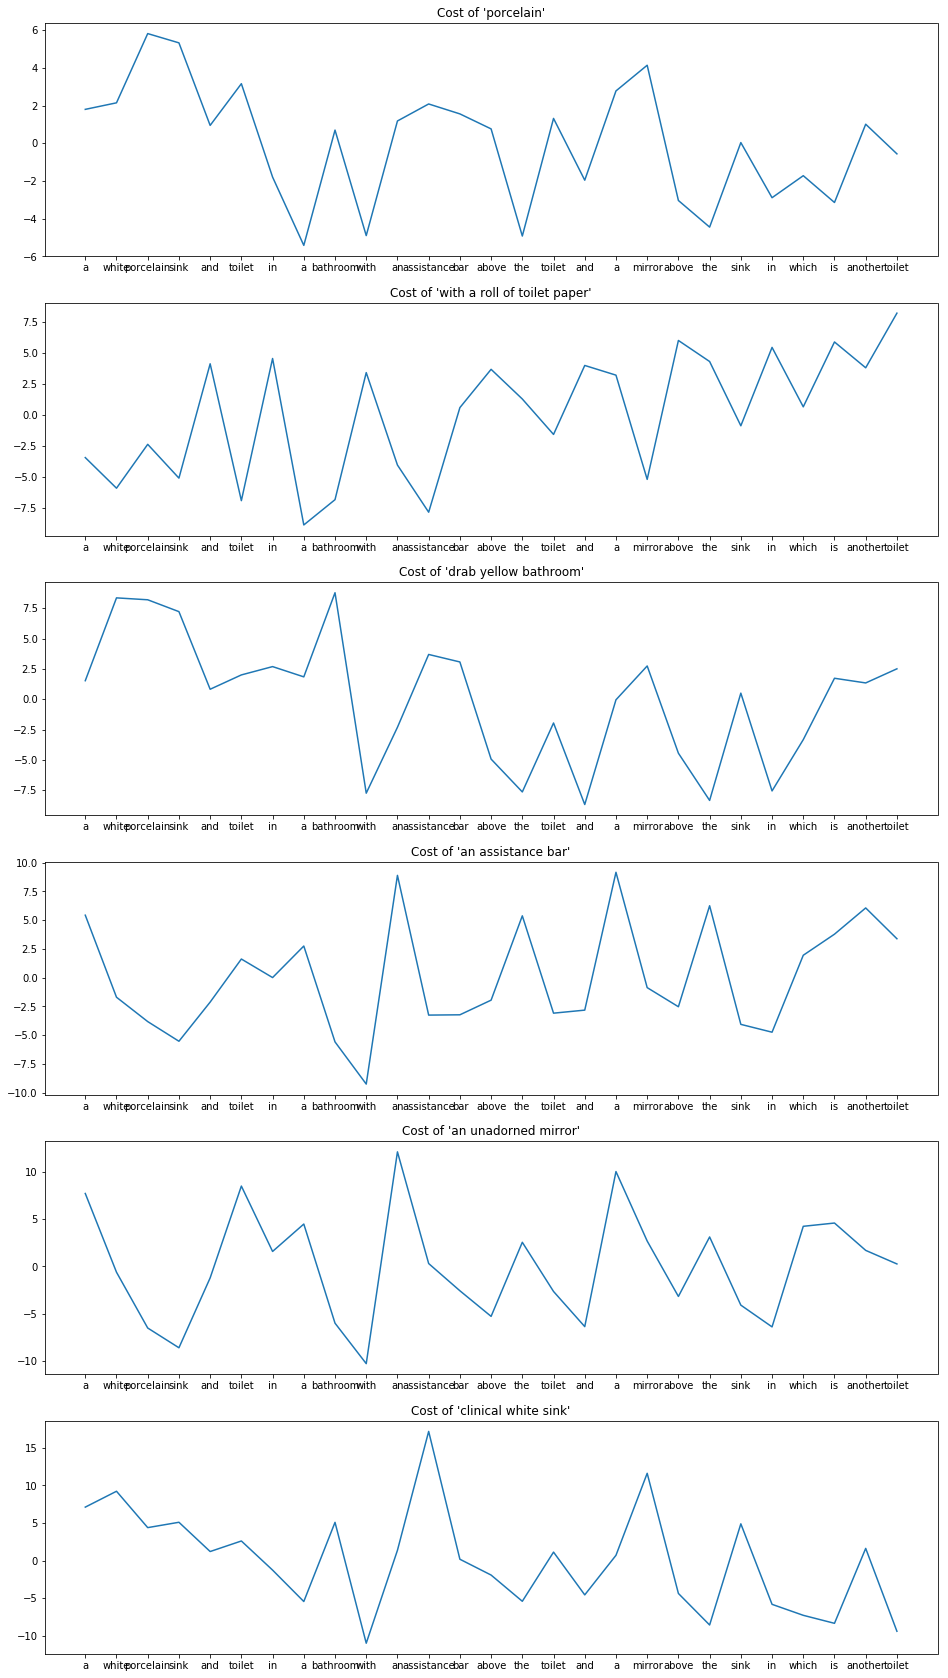

In [52]:
n_phrases = len(phrase_logprobs)
fig, axs = plt.subplots(nrows=n_phrases, figsize=(16, 5*n_phrases))
for i, phrase in enumerate(phrase_logprobs):
    ax = axs[i]
    ax.plot(phrase_logprobs[phrase] + phrase_offsets[phrase])
    ax.set_xticks(np.arange(len(all_tokens)))
    ax.set_xticklabels(all_tokens)
    ax.set_title("Cost of {!r}".format(phrase));

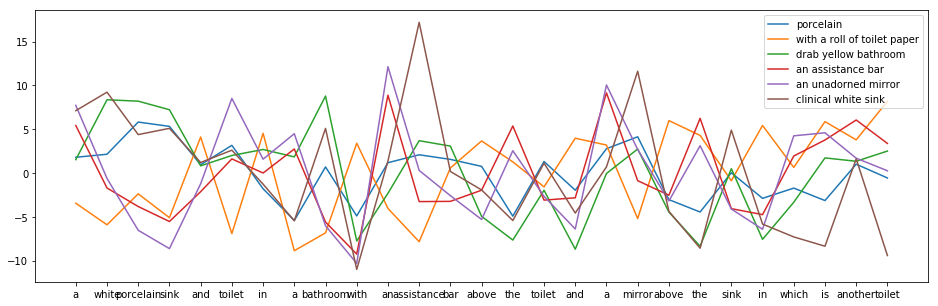

In [55]:
n_phrases = len(phrase_logprobs)
fig, ax = plt.subplots(figsize=(16, 5))
for i, phrase in enumerate(phrase_logprobs):
    ax.plot(phrase_logprobs[phrase] + phrase_offsets[phrase], label=phrase)
    ax.set_xticks(np.arange(len(all_tokens)))
    ax.set_xticklabels(all_tokens)
plt.legend();

In [62]:
threshold = 5
model = onmt_model_2.models['coco_lm']
all_tokens = sample_text.split()
for i in range(len(all_tokens)):
    print()
    tokens = all_tokens[:i]
    print(' '.join(tokens))
    phrases = sorted(phrases_to_evaluate)
    candidate_scores = []
    for phrase in phrases:
        raw_logprobs = -model.eval_logprobs(('.',), tokens + phrase, use_eos=False)
        logprob = np.sum(raw_logprobs[-len(phrase):])
        candidate_scores.append(dict(
            phrase=phrase,
            logprob=logprob,
            score=logprob + phrase_offsets[' '.join(phrase)]))
    candidate_scores.sort(key=lambda ent: ent['score'], reverse=True)
    n = 0
    for candidate in candidate_scores:
        if candidate['score'] > threshold:
            print('{:6.2f} {}'.format(candidate['logprob'], ' '.join(candidate['phrase'])))
            n += 1
            if n == 3:
                break
    



-33.29 an unadorned mirror
-38.41 clinical white sink
-26.37 an assistance bar

a
-36.30 clinical white sink
-21.87 drab yellow bathroom

a white
-22.02 drab yellow bathroom
 -7.36 porcelain

a white porcelain
-23.00 drab yellow bathroom
 -7.85 porcelain
-40.43 clinical white sink

a white porcelain sink

a white porcelain sink and
-32.51 an unadorned mirror

a white porcelain sink and toilet

a white porcelain sink and toilet in

a white porcelain sink and toilet in a
-21.44 drab yellow bathroom
-40.44 clinical white sink

a white porcelain sink and toilet in a bathroom

a white porcelain sink and toilet in a bathroom with
-28.88 an unadorned mirror
-22.91 an assistance bar

a white porcelain sink and toilet in a bathroom with an
-28.34 clinical white sink

a white porcelain sink and toilet in a bathroom with an assistance

a white porcelain sink and toilet in a bathroom with an assistance bar

a white porcelain sink and toilet in a bathroom with an assistance bar above
-26.42 an as

In [28]:
[x for x in onmt_model_2.models['coco_lm'].fields['tgt'].vocab.itos if x.startswith('porc')]

['porch',
 'porcelain',
 'porcupine',
 'porcelan',
 'porcelian',
 'porcelin',
 'porceline',
 'porches']

# Get some examples by word

In [68]:
texts = dataset[dataset.stimulus == '247576'].text
for text in texts:
    if 'car' in text:
        print(text[text.index('car') - 10:][:30])

d a black car drive down the n
r bus and car approach an empt
next to a car with people walk
d a black car come down a euro
o a black car is going down th
ty with a car and a red bus an
ecker bus carries the passenge
ople with cars and a bus in th
bus and a car driving down a s
bus, some cars, a black fence 
bus and a car and people in th
d bus and car drive down the s
dings and cars
a bus and car driving down the
a bus and car drive by
bus and a car behind it the ci
road with cars behind it throu
 red bus, cars, people and bui
h a black car and a red double
et with a car behind it
e a black car looks to pass
r bus and car on a street runn
reet with cars, a large red bu
reet with cars and people alon


In [69]:
import re

In [75]:
texts = dataset[dataset.stimulus == '247576'].text
car_befores = []
for text in texts:
    match = re.search(r'(\w+ \w+ \w+) people', text)
    if match:
        car_befores.append(match.group(1))
car_befores.sort(key=lambda x: ' '.join(x.split()[::-1]))
car_befores

['artisan buildings and',
 'historic buildings and',
 'story buildings and',
 'tall buildings and',
 'tall buildings and',
 'with buildings and',
 'decker bus and',
 'red bus and',
 'a car and',
 'with cars and',
 'the left and',
 'either side and',
 'the right has',
 'bus and many',
 'bus and many',
 'city with many',
 'street with many',
 'a bunch of',
 'a crowd of',
 'a crowd of',
 'city full of',
 'sidewalk full of',
 'a group of',
 'a lot of',
 'with lot of',
 'and lots of',
 'and lots of',
 'with lots of',
 'a multitude of',
 'england with several',
 'bus and some',
 'comes barreling towards',
 'to pick up',
 'city street while',
 'the street while',
 'the street while',
 'a car with',
 'is filled with',
 'street filled with',
 'of london with',
 'sidewalk packed with',
 'is populated with',
 'is populated with',
 'the road with',
 'a street with',
 'busy street with',
 'busy street with',
 'busy street with',
 'large street with',
 'city streets with',
 'street swarmed with']

# What are low-specificity captions missing?

In [94]:
all_freqs = []
selected_texts = dataset.sort_values('predicted_details').query('stimulus == "247576"').text
for text in selected_texts:
    all_freqs.append([wordfreq.zipf_frequency(tok, 'en') for tok in wordfreq.tokenize(text, 'en')])
longest = max(len(freqs) for freqs in all_freqs)
all_freqs_padded = np.full((len(selected_texts), longest), np.nan)
words_padded = np.full((len(selected_texts), longest), '     ')
for i, freqs in enumerate(all_freqs):
    all_freqs_padded[i,:len(freqs)] = freqs
    words_padded[i,:len(freqs)] = wordfreq.tokenize(selected_texts.iloc[i], 'en')

In [95]:
import seaborn as sns

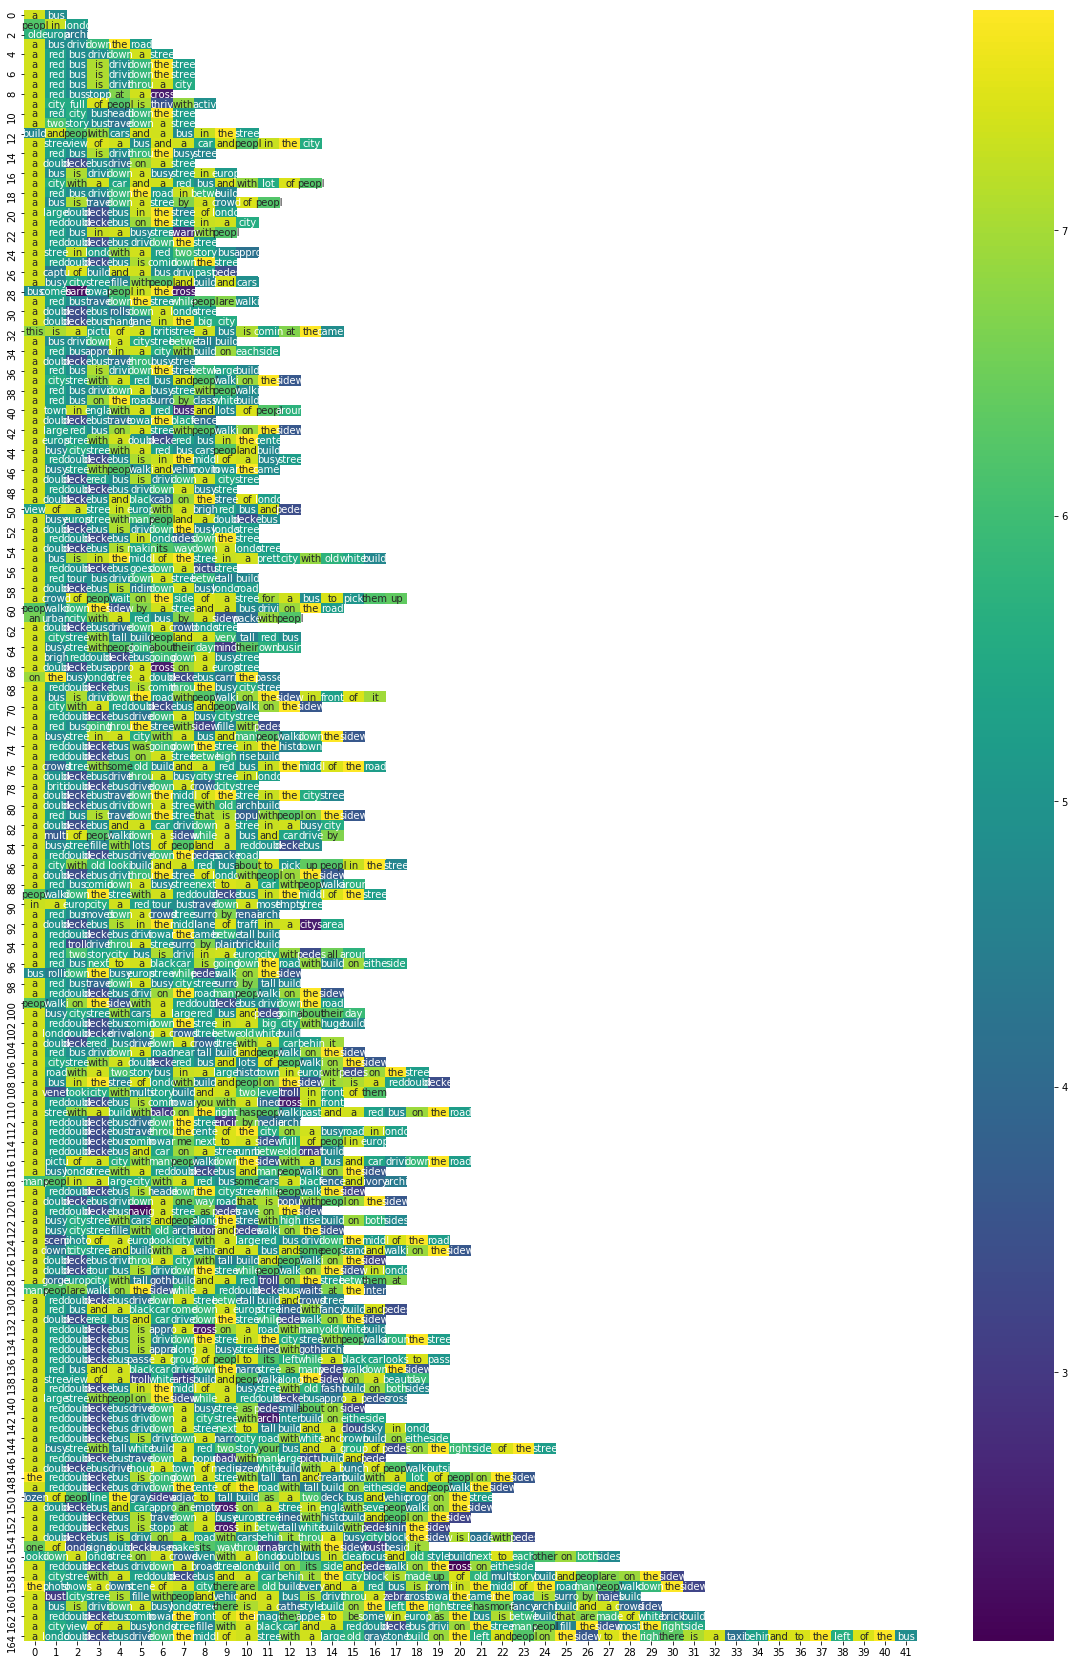

In [97]:
plt.figure(figsize=(20, 30))
sns.heatmap(all_freqs_padded, cmap=plt.cm.viridis, annot=words_padded, fmt="s")

In [87]:
sns.heatmap??

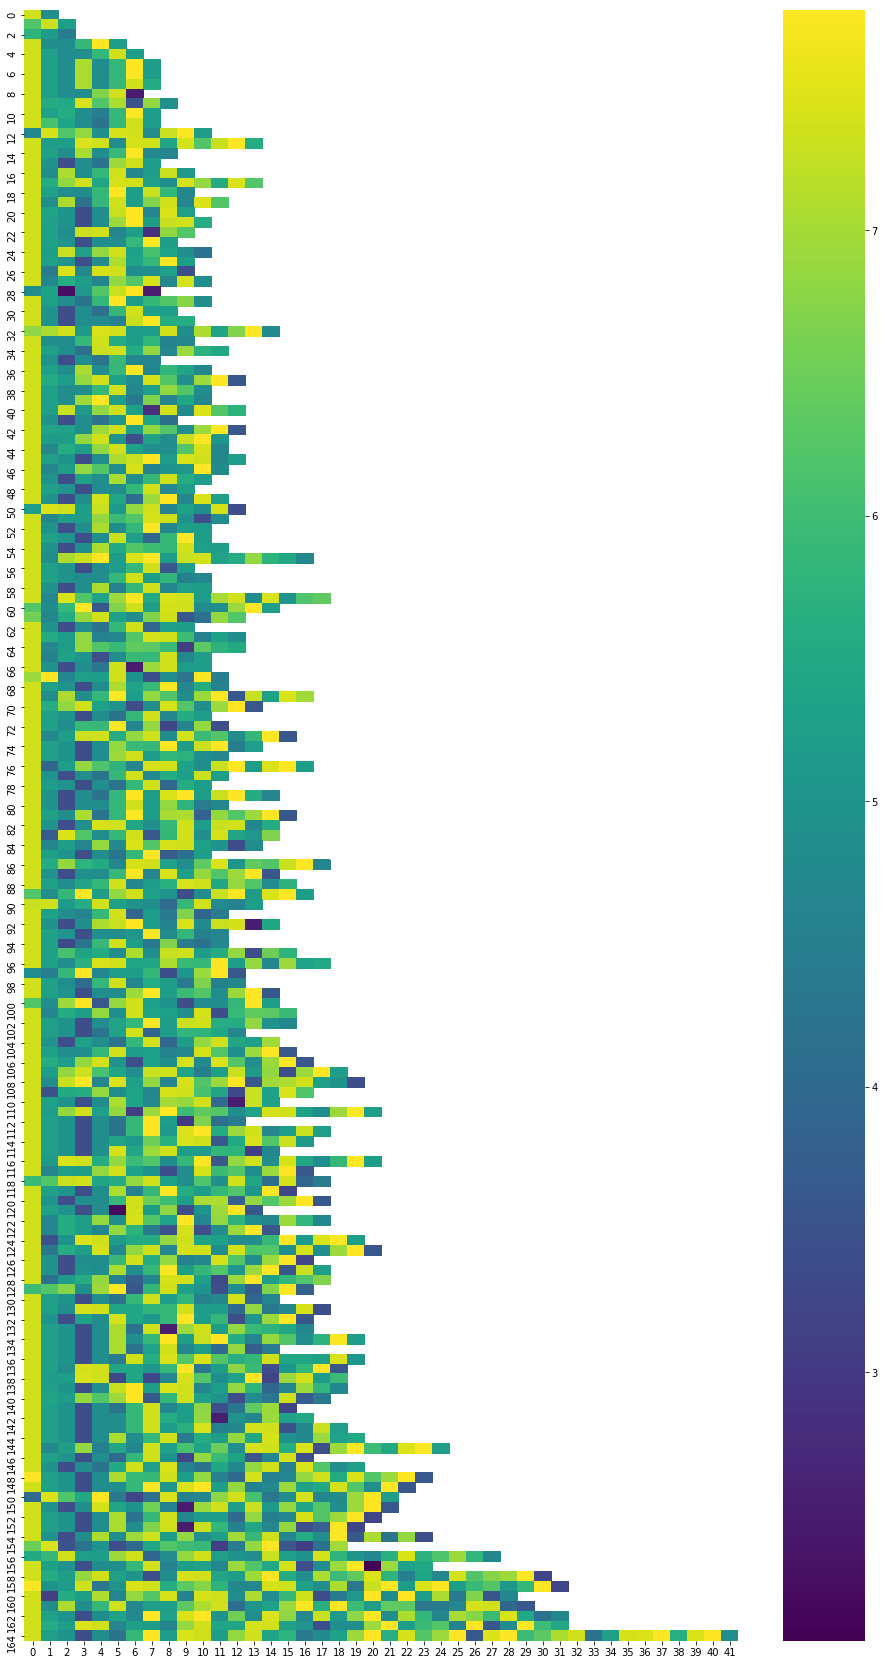

In [86]:
plt.figure(figsize=(16, 30))
plt.
sns.heatmap(all_freqs_padded, cmap=plt.cm.viridis)

# Aside, curiosity: is there any difference in this measure between writing conditions?

In [46]:
import seaborn as sns

/Users/kcarnold/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


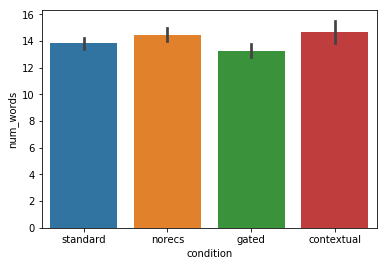

In [66]:
sns.barplot(x='condition', y='num_words', data=dataset)

/Users/kcarnold/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


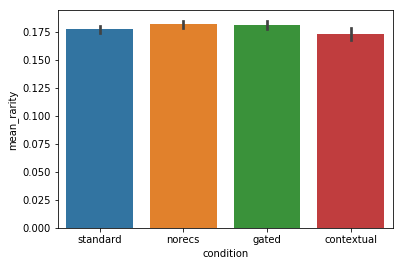

In [69]:
sns.barplot(x='condition', y='mean_rarity', data=dataset)

/Users/kcarnold/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


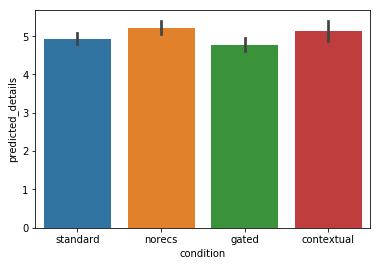

In [47]:
sns.barplot(x='condition', y='predicted_details', data=dataset)

In [48]:
import statsmodels.formula.api as smf

In [74]:
cond_levels = ['norecs', 'gated', 'standard', 'contextual']
smf.ols('mean_rarity ~ C(condition, levels=cond_levels) + C(stimulus)', data=dataset).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            mean_rarity   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     12.22
Date:                Sat, 13 Oct 2018   Prob (F-statistic):           9.53e-28
Time:                        15:11:28   Log-Likelihood:                 3527.1
No. Observations:                1908   AIC:                            -7024.
Df Residuals:                    1893   BIC:                            -6941.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                          0.1937      0.003     59.976      0.000       0.187       0.200
C(condition, levels=cond_levels)[T.gated]         -0.0004      0.002     -0.179      0.858      -0.005       0.004
C(condition, levels=cond_levels)[T.standard]      -0.0045      0.002     -2.078      0.038      -0.009      -0.000
C(condition, levels=cond_levels)[T.contextual]    -0.0097      0.003     -3.060      0.002      -0.016      -0.003
C(stimulus)[T.223777]                             -0.0239      0.004     -5.684      0.000      -0.032      -0.016
C(stimulus)[T.227326]                             -0.0143      0.004     -3.400      0.001      -0.023      -0.006
C(stimulus)[T.236272]                             -0.0137      0.004     -3.113      0.002      -0.022      -0.005
C(stimulus)[T.240275]                              0.0004      0.004      0.093      0.926      -0.008       0.009
C(stimulus)[T.247576]                             -0.0144      0.004     -3.429      0.001      -0.023      -0.006
C(stimulus)[T.275449]                             -0.0164      0.004     -3.899      0.000      -0.025      -0.008
C(stimulus)[T.280480]                             -0.0242      0.004     -5.522      0.000      -0.033      -0.016
C(stimulus)[T.396295]                              0.0091      0.004      2.159      0.031       0.001       0.017
C(stimulus)[T.431140]                             -0.0247      0.004     -5.871      0.000      -0.033      -0.016
C(stimulus)[T.527375]                             -0.0223      0.004     -5.093      0.000      -0.031      -0.014
C(stimulus)[T.71815]                              -0.0008      0.004     -0.184      0.854      -0.009       0.007
==============================================================================
Omnibus:                      235.708   Durbin-Watson:                   1.708
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              500.089
Skew:                           0.744   Prob(JB):                    2.55e-109
Kurtosis:                       5.018   Cond. No.                         13.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [71]:
fit = smf.mixedlm(
    "predicted_details ~ C(condition)",
    data=dataset,
    groups=dataset['participant'],
    re_formula='1', vc_formula={'stimulus': '1 + C(condition)'}
).fit()
fit.summary()


<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
===================================================================
Model:              MixedLM  Dependent Variable:  predicted_details
No. Observations:   1908     Method:              REML             
No. Groups:         165      Scale:               1.5497           
Min. group size:    9        Likelihood:          -3439.7023       
Max. group size:    12       Converged:           Yes              
Mean group size:    11.6                                           
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 5.069    0.156 32.535 0.000  4.764  5.375
C(condition)[T.gated]    -0.251    0.145 -1.727 0.084 -0.535  0.034
C(condition)[T.norecs]    0.164    0.132  1.238 0.216 -0.095  0.423
C(condition)[T.standard] -0.126    0.132 -0.952 0.341 -0.385  0.133
Group RE                  1.552    0.210                           
stimulus RE               0.409    0.072                           
===================================================================

"""

In [56]:
dataset['predicted_details_z'] = dataset.predicted_details - dataset.groupby('stimulus').predicted_details.transform('mean')

In [63]:
mean_over_trials = dataset.groupby(['participant', 'condition']).predicted_details_z.mean().reset_index()

In [65]:
smf.ols('predicted_details_z ~ C(condition)', data=mean_over_trials).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     predicted_details_z   R-squared:                       0.012
Model:                             OLS   Adj. R-squared:                  0.006
Method:                  Least Squares   F-statistic:                     1.974
Date:                 Sat, 13 Oct 2018   Prob (F-statistic):              0.117
Time:                         15:03:10   Log-Likelihood:                -940.56
No. Observations:                  495   AIC:                             1889.
Df Residuals:                      491   BIC:                             1906.
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.1579      0.221      0.714      0.475      -0.276       0.592
C(condition)[T.gated]       -0.3954      0.270     -1.467      0.143      -0.925       0.134
C(condition)[T.norecs]       0.0533      0.255      0.209      0.834      -0.447       0.554
C(condition)[T.standard]    -0.2248      0.255     -0.883      0.378      -0.725       0.276
==============================================================================
Omnibus:                      110.958   Durbin-Watson:                   0.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              311.456
Skew:                           1.076   Prob(JB):                     2.33e-68
Kurtosis:                       6.236   Cond. No.                         7.10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""